In [1]:
import jax.numpy as jnp
from jax import random, jit, config, vmap
import matplotlib.pyplot as plt
from functools import partial
config.update("jax_enable_x64", True)

%config InlineBackend.figure_format='retina'

In [2]:
! git init .
! git remote add origin https://github.com/VLSF/SDC
! git pull origin main

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 123 (delta 63), reused 94 (delta 37), pack-reused 0
Receiving objects: 100% (123/123), 24.11 KiB | 1.85 MiB/s, done.
Resolving deltas: 100% (63/63), done.
From https://github.com/VLSF/SDC
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [3]:
from integrators import RK4, Explicit_Euler, Implicit_Euler
from sdc_integrators import RK4 as RK4_c
from sdc_integrators import Explicit_Euler as Explicit_Euler_c
from sdc_integrators import Implicit_Euler as Implicit_Euler_c
from misc import utils, Chebyshev, equations

In [4]:
def SDC_res(integrator, equation, N_points, N_sdc, *args):
    t0, t1 = 0.0, 1
    t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

    integrators = {
        "RK4": RK4.integrator, 
        "Explicit Euler": Explicit_Euler.integrator,
        "Implicit Euler": Implicit_Euler.integrator,
        "Implicit Euler (jac)": Implicit_Euler.integrator_J,
    }

    equation_data = equations.get_ODE(equation, *args)

    key = random.PRNGKey(11)
    if equation == "Lorenz":
        exact_solution = random.normal(key, (3, 1))
    elif equation == "Van der Pol":
        exact_solution = random.normal(key, (2, 1))
    else:
        exact_solution = equation_data["exact"](t)
    F = equation_data["F"]
    inv_dF = equation_data["inv_dF"]

    exact_solution = jnp.expand_dims(exact_solution, 0) if exact_solution.ndim == 1 else exact_solution
    u0 = exact_solution[:, 0]

    R = []
    if integrator == "Implicit Euler (jac)":
        values = integrators[integrator](u0, F, inv_dF, N_points, t0, t1, 1)
        res = jnp.linalg.norm(jnp.ravel(utils.residual(values, F, t0, t1)), ord=jnp.inf)
        R.append(res.item())
        for i in range(N_sdc):
            values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
            res = jnp.linalg.norm(jnp.ravel(utils.residual(values, F, t0, t1)), ord=jnp.inf)
            R.append(res.item())

    elif integrator == "Implicit Euler":
        values = integrators[integrator](u0, F, N_points, t0, t1, 1)
        res = jnp.linalg.norm(jnp.ravel(utils.residual(values, F, t0, t1)), ord=jnp.inf)
        R.append(res.item())
        for i in range(N_sdc):
            values = Implicit_Euler_c.deferred_correction(values, F, t0, t1, 1)
            res = jnp.linalg.norm(jnp.ravel(utils.residual(values, F, t0, t1)), ord=jnp.inf)
            R.append(res.item())

    elif integrator == "Explitic Euler":
        values = integrators[integrator](u0, F, N_points, t0, t1)
        res = jnp.linalg.norm(jnp.ravel(utils.residual(values, F, t0, t1)), ord=jnp.inf)
        R.append(res.item())
        for i in range(N_sdc):
            values = Explicit_Euler.deferred_correction(values, F, t0, t1)
            res = jnp.linalg.norm(jnp.ravel(utils.residual(values, F, t0, t1)), ord=jnp.inf)
            R.append(res.item())

    else:
        values = integrators[integrator](u0, F, N_points, t0, t1)
        res = jnp.linalg.norm(jnp.ravel(utils.residual(values, F, t0, t1)), ord=jnp.inf)
        R.append(res.item())
        for i in range(N_sdc):
            values = RK4_c.deferred_correction(values, F, t0, t1)
            res = jnp.linalg.norm(jnp.ravel(utils.residual(values, F, t0, t1)), ord=jnp.inf)
            R.append(res.item())

    return jnp.array(R)

In [5]:
def AA_res(integrator, equation, N_points, N_sdc, N_AA, *args):
    t0, t1 = 0.0, 1
    t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

    integrators = {
        "RK4": RK4.integrator, 
        "Explicit Euler": Explicit_Euler.integrator,
        "Implicit Euler": Implicit_Euler.integrator,
        "Implicit Euler (jac)": Implicit_Euler.integrator_J,
    }

    equation_data = equations.get_ODE(equation, *args)

    key = random.PRNGKey(11)
    if equation == "Lorenz":
        exact_solution = random.normal(key, (3, 1))
    elif equation == "Van der Pol":
        exact_solution = random.normal(key, (2, 1))
    else:
        exact_solution = equation_data["exact"](t)
    F = equation_data["F"]
    inv_dF = equation_data["inv_dF"]

    exact_solution = jnp.expand_dims(exact_solution, 0) if exact_solution.ndim == 1 else exact_solution
    u0 = exact_solution[:, 0]

    R = []
    if integrator == "Implicit Euler (jac)":
        values = integrators[integrator](u0, F, inv_dF, N_points, t0, t1, 1)
        H = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, N_sdc, N_AA, t0, t1, 1)

    elif integrator == "Implicit Euler":
        values = integrators[integrator](u0, F, N_points, t0, t1, 1)
        H = Implicit_Euler_c.AA_deferred_correction(values, F, N_sdc, N_AA, t0, t1, 1)

    elif integrator == "Explitic Euler":
        values = integrators[integrator](u0, F, N_points, t0, t1)
        H = Explicit_Euler_c.AA_deferred_correction(values, F, N_sdc, N_AA, t0, t1)

    else:
        values = integrators[integrator](u0, F, N_points, t0, t1)
        H = RK4_c.AA_deferred_correction(values, F, N_sdc, N_AA, t0, t1)

    R = jnp.linalg.norm(vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(H, F, t0, t1).reshape(-1, H.shape[-1]), ord=jnp.inf, axis=0)
    return R

# Lorenz equation

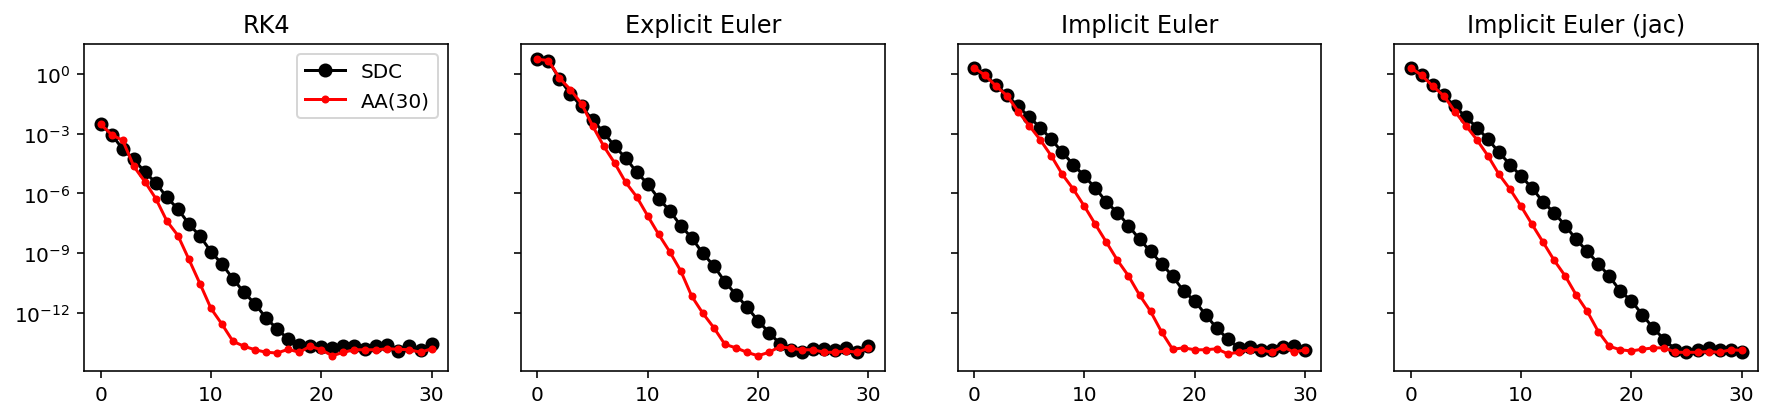

In [6]:
N_AA = 30
N_SDC = 30
integrators = ["RK4", "Explicit Euler", "Implicit Euler", "Implicit Euler (jac)"]

fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharey="row")

for i in range(4):
    res_1 = SDC_res(integrators[i], "Lorenz", 100, N_SDC)
    res_2 = AA_res(integrators[i], "Lorenz", 100, N_SDC, N_AA)

    ax[i].set_yscale("log")
    ax[i].plot(res_1, "o-", color="black", label="SDC")
    ax[i].plot(res_2, ".-", color="red", label=f"AA({N_AA})")
    ax[i].set_title(integrators[i])
    if i == 0:
        ax[i].legend()

# Van der Pol oscillator

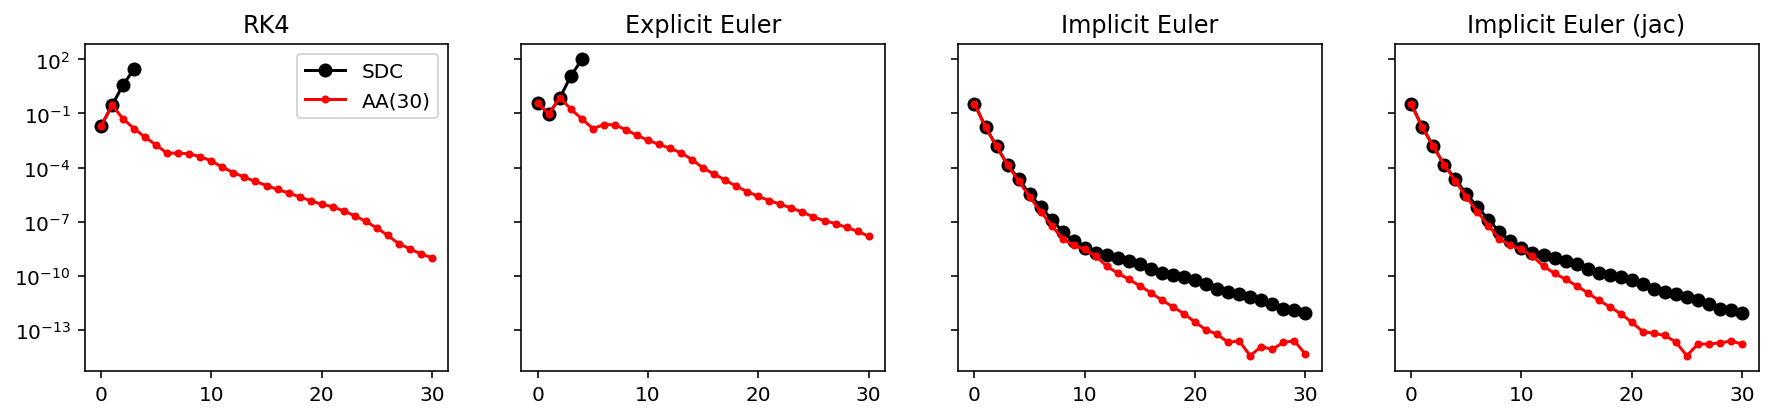

In [7]:
N_AA = 30
N_SDC = 30
epsilon = 0.01
integrators = ["RK4", "Explicit Euler", "Implicit Euler", "Implicit Euler (jac)"]

fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharey="row")

for i in range(4):
    res_1 = SDC_res(integrators[i], "Van der Pol", 100, N_SDC, epsilon)
    res_2 = AA_res(integrators[i], "Van der Pol", 100, N_SDC, N_AA, epsilon)

    ax[i].set_yscale("log")
    ax[i].plot(res_1, "o-", color="black", label="SDC")
    ax[i].plot(res_2, ".-", color="red", label=f"AA({N_AA})")
    ax[i].set_title(integrators[i])
    if i == 0:
        ax[i].legend()